In [21]:
# import datasets

import pandas as pd

cols = ['X', 'Y']
df_square = pd.read_csv('./Datasets/square.txt', sep=" ", names=cols, header=None)

<AxesSubplot: xlabel='X', ylabel='Y'>

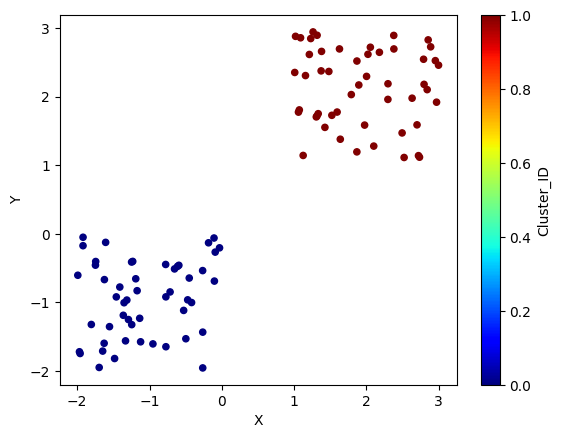

In [22]:
# implement spectral clustering

from sklearn import cluster
import pandas as pd

spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=10)
spectral.fit(df_square)
df_square['Cluster_ID'] = spectral.labels_

# plot the clusters

df_square.plot.scatter(x='X',y='Y',c='Cluster_ID',colormap='jet')

In [24]:
# split the clusters into vectors

cluster_0 = df_square[df_square['Cluster_ID'] == 0]
del cluster_0['Cluster_ID']
cluster_0 = cluster_0.to_numpy().tolist()

cluster_1 = df_square[df_square['Cluster_ID'] == 1]
del cluster_1['Cluster_ID']
cluster_1 = cluster_1.to_numpy().tolist()

# implement cosine similarity measure for the 2 clusters

from scipy import spatial
import numpy as np

cos_sim = []
for i in range(len(cluster_0)):
    sim = 1 - spatial.distance.cosine(cluster_0[i], cluster_1[i])
    cos_sim.append(sim)

print('Cosine Similarity Average: ', np.average(cos_sim))


Cosine Similarity Average:  -0.9118839688838639


In [25]:
# implement gaussian kernel similarity

def gaussian_sim (x, y, sigma): 
    return np.exp (- (np.linalg.norm (x - y) ** 2) / (2 * sigma ** 2))

# set bandwidth parameter
sigma = 1

# convert clusters from list to array to fit the function
cluster_0 = np.array(cluster_0)
cluster_1 = np.array(cluster_1)

# calculate similarity matrix
similarity_matrix = np.zeros ((len (cluster_0), len (cluster_1)))

for i in range (len (cluster_0)): 
    for j in range (len (cluster_0)): 
        similarity_matrix [i, j] = gaussian_sim(cluster_0[i], cluster_1[j], sigma)

print('Gaussian Similarity Average: ', np.average(similarity_matrix))

Gaussian Similarity Average:  0.0028444072795836355
